<a href="https://colab.research.google.com/github/Zhiyuan-03/AI_in_Transportation_Exercise/blob/main/Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Descriptive analysis

In [2]:
from google.colab import files

# Upload files
uploaded = files.upload()

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from tensorflow.keras import models, layers
from tensorflow.keras import callbacks



# Read the dataset
df = pd.read_csv('Dataset-PT.csv', skiprows=1)


In [4]:
# Basic structure
print(df.info())
print(df.head())

# Summary statistics for numeric features
print(df.describe())

# Missing values
print(df.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545103 entries, 0 to 545102
Data columns (total 31 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   calendar_date                      545103 non-null  int64  
 1   route_id                           545103 non-null  int64  
 2   bus_id                             545103 non-null  int64  
 3   stop_sequence                      545103 non-null  int64  
 4   arrival_delay                      545103 non-null  int64  
 5   dwell_time                         545103 non-null  int64  
 6   travel_time_for_previous_section   545103 non-null  int64  
 7   scheduled_travel_time              545103 non-null  int64  
 8   upstream_stop_delay                545103 non-null  int64  
 9   origin_delay                       545103 non-null  int64  
 10  previous_bus_delay                 545103 non-null  int64  
 11  previous_trip_travel_time          5451

In [5]:
print(df.columns.tolist())


['calendar_date', 'route_id', 'bus_id', 'stop_sequence', 'arrival_delay', 'dwell_time', 'travel_time_for_previous_section', 'scheduled_travel_time', 'upstream_stop_delay', 'origin_delay', 'previous_bus_delay', 'previous_trip_travel_time', 'traffic_condition', 'recurrent_delay', 'weather', 'temperature', 'day_of_week', 'time_of_day', 'factor(weather)Light_Rain', 'factor(weather)Light_Snow', 'factor(weather)Normal', 'factor(weather)Rain', 'factor(weather)Snow', 'factor(temperature)Cold', 'factor(temperature)Extra_cold', 'factor(temperature)Normal', 'factor(day_of_week)weekday', 'factor(day_of_week)weekend', 'factor(time_of_day)Afternoon_peak', 'factor(time_of_day)Morning_peak', 'factor(time_of_day)Off-peak']


In [6]:
cat_cols = ['day_of_week', 'time_of_day', 'weather', 'temperature']
for col in cat_cols:
    print(f"\n{col} distribution:")
    print(df[col].value_counts(normalize=True)*100)



day_of_week distribution:
day_of_week
weekday    76.71009
weekend    23.28991
Name: proportion, dtype: float64

time_of_day distribution:
time_of_day
OP    62.643023
AP    20.867799
MP    16.489177
Name: proportion, dtype: float64

weather distribution:
weather
Normal        94.472237
Light Rain     2.446877
Light Snow     1.783149
Snow           0.678587
Rain           0.619149
Name: proportion, dtype: float64

temperature distribution:
temperature
Normal        86.933479
Cold          11.273466
Extra cold     1.793056
Name: proportion, dtype: float64


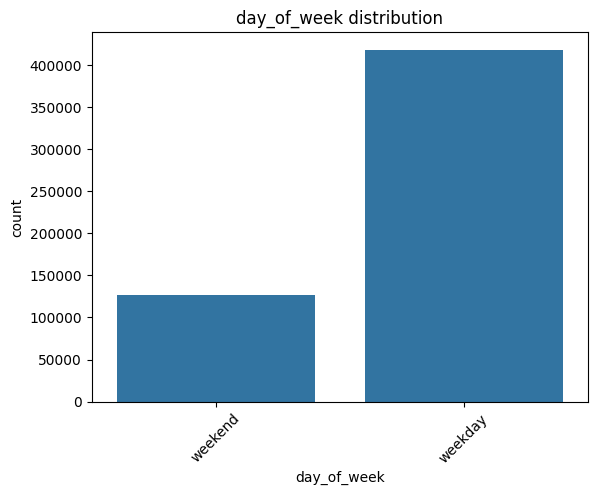

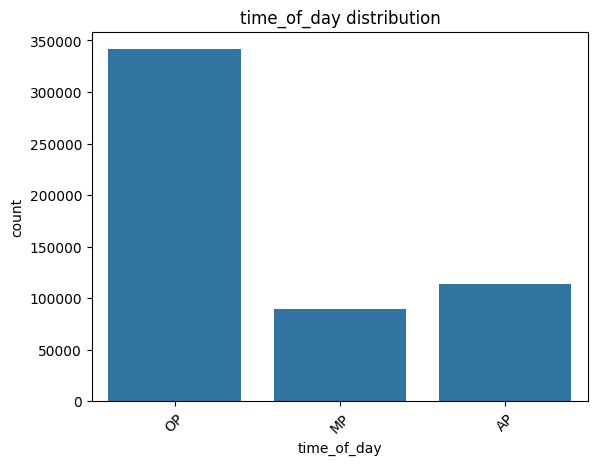

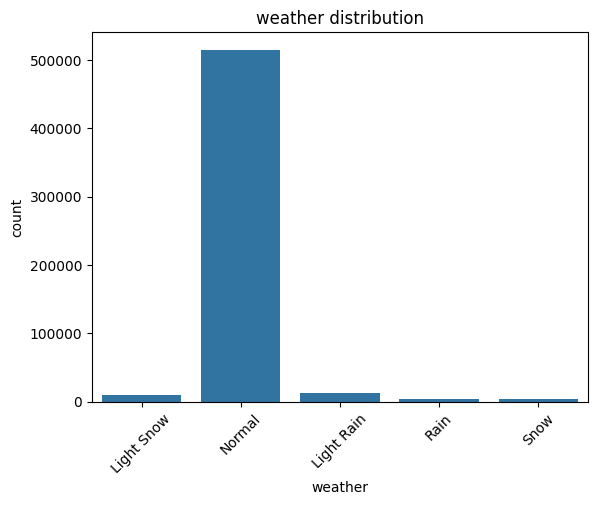

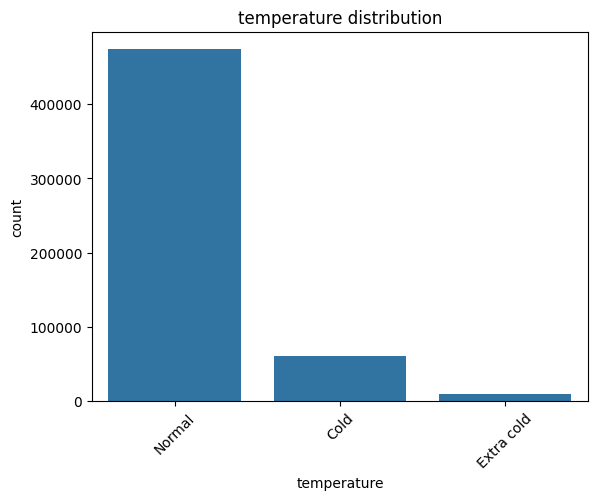

In [7]:
for col in cat_cols:
    sns.countplot(data=df, x=col)
    plt.title(f"{col} distribution")
    plt.xticks(rotation=45)
    plt.show()


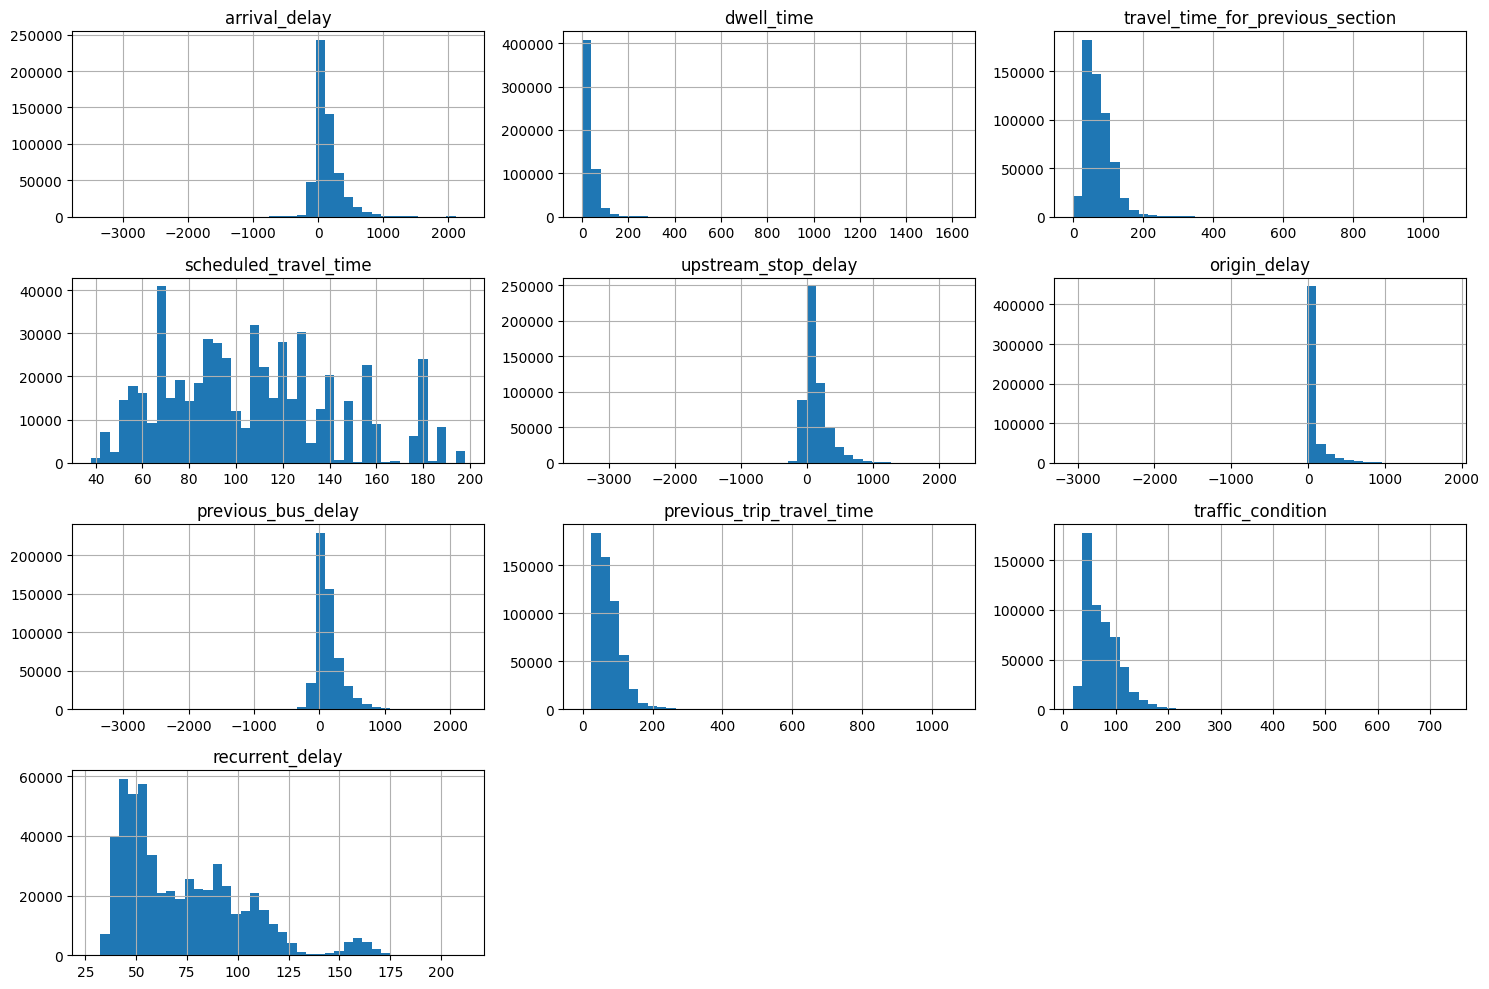

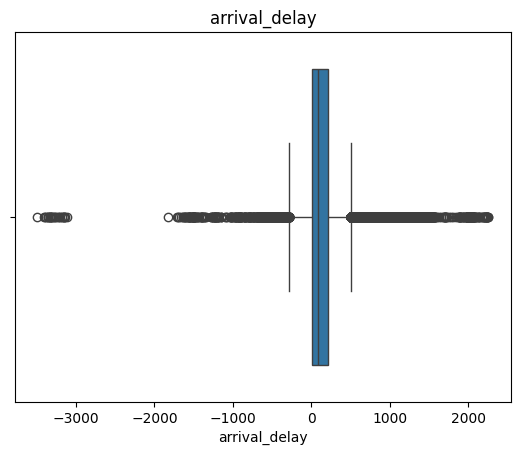

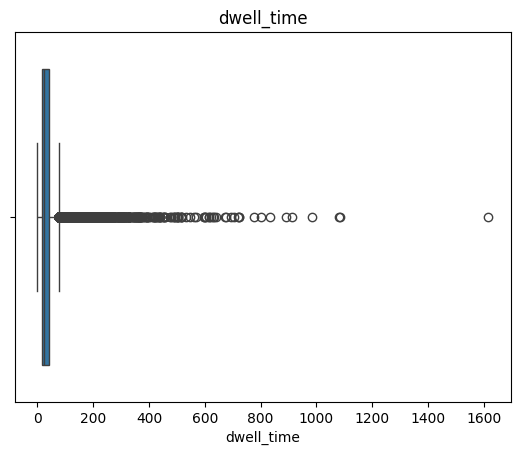

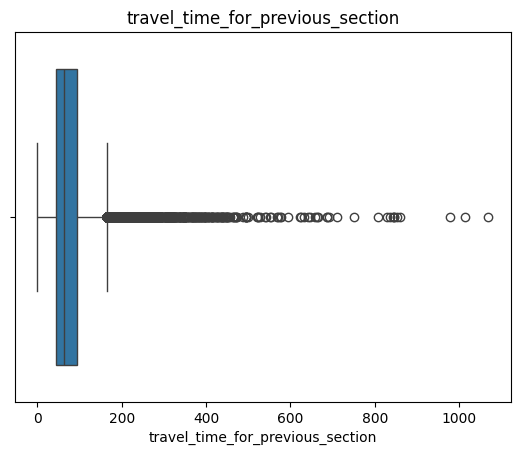

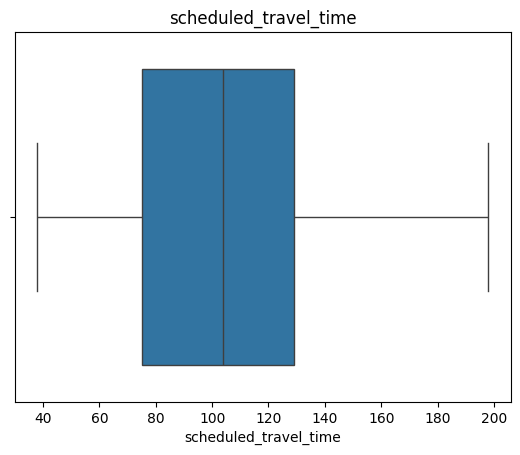

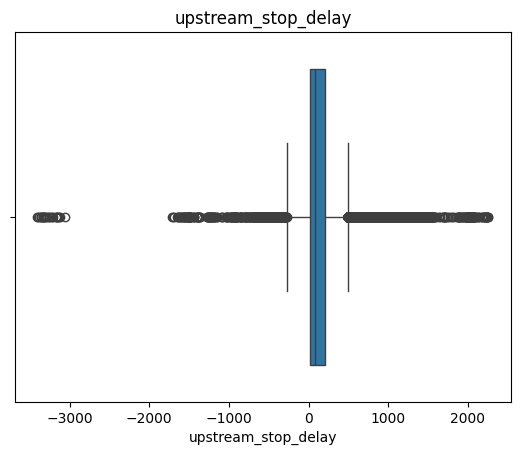

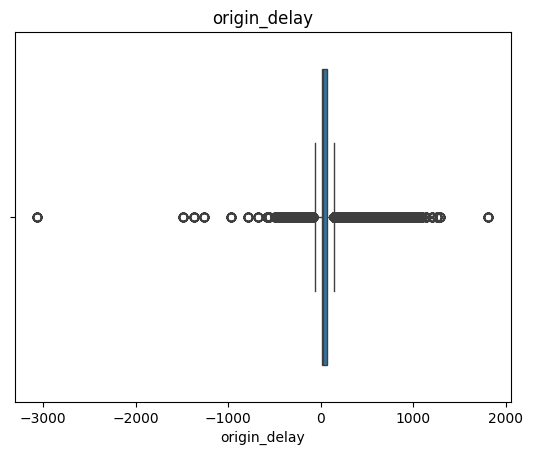

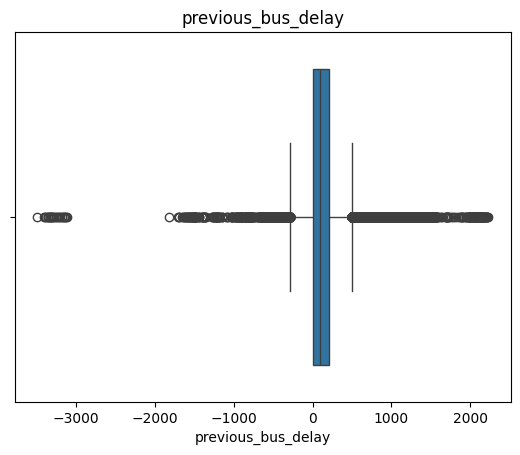

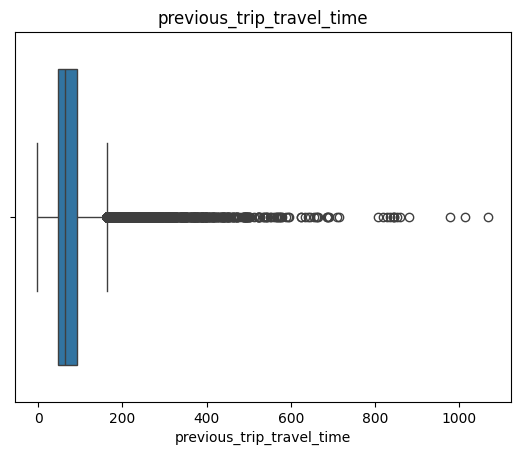

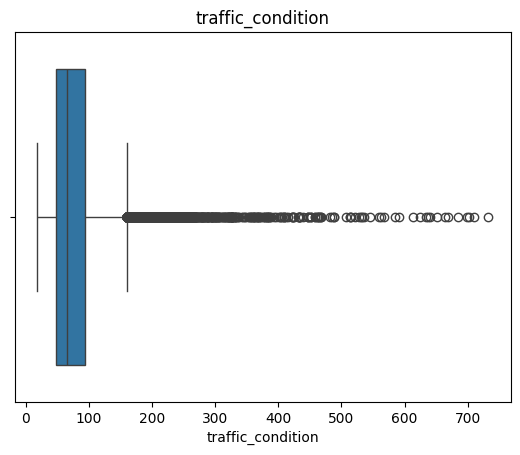

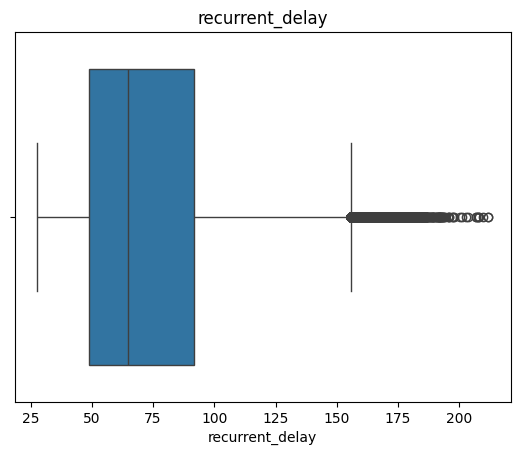

In [8]:
num_cols = [
    'arrival_delay','dwell_time','travel_time_for_previous_section',
    'scheduled_travel_time','upstream_stop_delay','origin_delay',
    'previous_bus_delay','previous_trip_travel_time',
    'traffic_condition','recurrent_delay'
]

# Histograms & boxplots
df[num_cols].hist(bins=40, figsize=(15,10))
plt.tight_layout()
plt.show()

for col in num_cols:
    sns.boxplot(x=df[col])
    plt.title(col)
    plt.show()


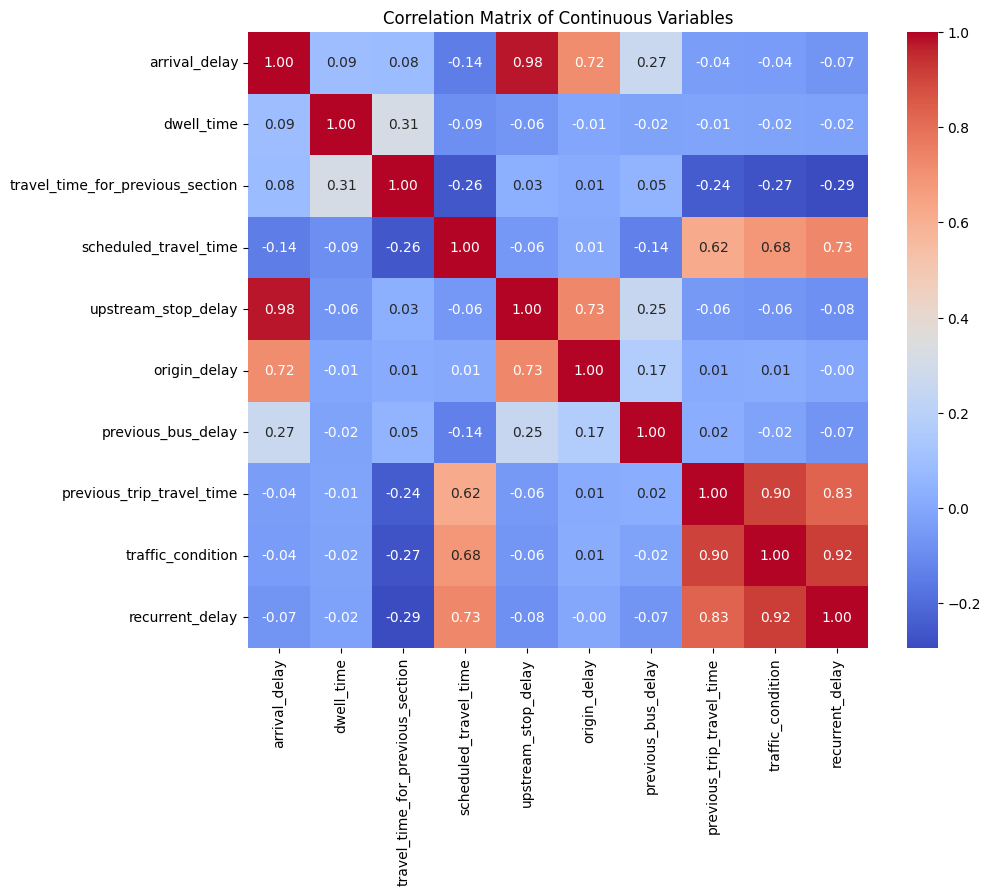

In [9]:
corr = df[num_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Continuous Variables")
plt.show()


In [10]:
df.groupby('time_of_day')['arrival_delay'].describe()


,count,mean,std,min,25%,50%,75%,max
time_of_day,,,,,,,,
AP,113751.0,100.254890,186.904289,-1656.0,-12.0,54.0,166.0,1605.0
MP,89883.0,100.345238,177.431529,-3493.0,-2.0,69.0,172.0,2210.0
OP,341469.0,155.652042,197.356115,-1349.0,26.0,105.0,233.0,2257.0


In [11]:
df.groupby('weather')['arrival_delay'].mean().sort_values()


,arrival_delay
weather,
Light Rain,101.520843
Light Snow,116.779733
Snow,131.268992
Normal,136.034216
Rain,161.584593


In [12]:
df.groupby('day_of_week')['arrival_delay'].mean()


,arrival_delay
day_of_week,
weekday,114.589024
weekend,202.108527


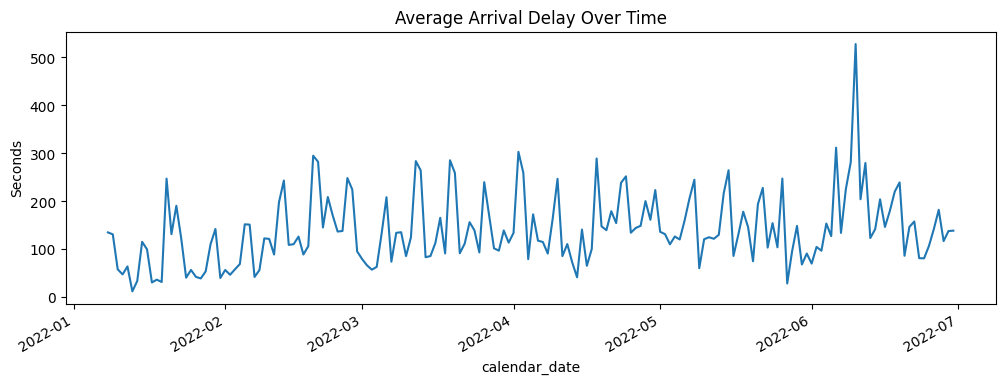

In [13]:
df['calendar_date'] = pd.to_datetime(df['calendar_date'], format='%Y%m%d')
daily_delay = df.groupby('calendar_date')['arrival_delay'].mean()
daily_delay.plot(figsize=(12,4))
plt.title("Average Arrival Delay Over Time")
plt.ylabel("Seconds")
plt.show()


In [14]:
for col in num_cols:
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    outliers = df[(df[col] < q1 - 1.5*iqr) | (df[col] > q3 + 1.5*iqr)]
    print(f"{col}: {len(outliers)} outliers")


arrival_delay: 28835 outliers
dwell_time: 30726 outliers
travel_time_for_previous_section: 9689 outliers
scheduled_travel_time: 0 outliers
upstream_stop_delay: 29886 outliers
origin_delay: 77571 outliers
previous_bus_delay: 29062 outliers
previous_trip_travel_time: 10476 outliers
traffic_condition: 9228 outliers
recurrent_delay: 14260 outliers


Data Preprocessing

In [15]:
# Missing values count
print(df.isna().sum())

# Example strategies
# Drop rows with too many missing values
df.dropna(thresh=len(df.columns)-3, inplace=True)  # allow ≤3 NaNs per row

# Fill numeric NaNs with median
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill categorical NaNs with mode
cat_cols = df.select_dtypes(include='object').columns
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])


calendar_date                        0
route_id                             0
bus_id                               0
stop_sequence                        0
arrival_delay                        0
dwell_time                           0
travel_time_for_previous_section     0
scheduled_travel_time                0
upstream_stop_delay                  0
origin_delay                         0
previous_bus_delay                   0
previous_trip_travel_time            0
traffic_condition                    0
recurrent_delay                      0
weather                              0
temperature                          0
day_of_week                          0
time_of_day                          0
factor(weather)Light_Rain            0
factor(weather)Light_Snow            0
factor(weather)Normal                0
factor(weather)Rain                  0
factor(weather)Snow                  0
factor(temperature)Cold              0
factor(temperature)Extra_cold        0
factor(temperature)Normal

In [16]:
df.drop_duplicates(inplace=True)


In [17]:
if 'calendar_date' in df.columns:
    df['calendar_date'] = pd.to_datetime(df['calendar_date'], format='%Y%m%d')


In [18]:
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')


In [19]:
cat_cols = ['day_of_week', 'time_of_day', 'weather', 'temperature']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)


In [20]:
from sklearn.preprocessing import StandardScaler

# Define numeric features to scale
num_cols = [
    'arrival_delay','dwell_time','travel_time_for_previous_section',
    'scheduled_travel_time','upstream_stop_delay','origin_delay',
    'previous_bus_delay','previous_trip_travel_time',
    'traffic_condition','recurrent_delay'
]

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])


In [21]:
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545103 entries, 0 to 545102
Data columns (total 36 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   calendar_date                      545103 non-null  datetime64[ns]
 1   route_id                           545103 non-null  int64         
 2   bus_id                             545103 non-null  int64         
 3   stop_sequence                      545103 non-null  int64         
 4   arrival_delay                      545103 non-null  float64       
 5   dwell_time                         545103 non-null  float64       
 6   travel_time_for_previous_section   545103 non-null  float64       
 7   scheduled_travel_time              545103 non-null  float64       
 8   upstream_stop_delay                545103 non-null  float64       
 9   origin_delay                       545103 non-null  float64       
 10  previous_bus_delay  

In [22]:
# Parse calendar_date (already in 'YYYY-MM-DD' format)
df["calendar_date"] = pd.to_datetime(df["calendar_date"], format="%Y-%m-%d")

# Estimate scheduled arrival time assuming service starts at 6:00 AM (21600 seconds)
df["scheduled_dt"] = df["calendar_date"] + pd.to_timedelta(21600 + df["scheduled_travel_time"], unit="s")

# Estimate actual arrival time by adding delay
df["actual_arrival_dt"] = df["scheduled_dt"] + pd.to_timedelta(df["arrival_delay"], unit="s")

# Extract calendar components
df["year"]       = df["calendar_date"].dt.year
df["month"]      = df["calendar_date"].dt.month
df["day"]        = df["calendar_date"].dt.day
df["dayofweek"]  = df["calendar_date"].dt.dayofweek  # 0 = Monday
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)

# Extract hour of actual arrival
df["arrival_hour"] = df["actual_arrival_dt"].dt.hour


In [23]:
# Relative position along the 28-stop route
df['route_progress'] = df['stop_sequence'] / 28

In [24]:
# Sort by bus, date, and stop sequence to ensure chronological order
df = df.sort_values(["bus_id", "calendar_date", "stop_sequence"])

# Initialize tracking variables
trip_ids = []
trip_counter = 0
last_bus_date = (None, None)
last_stop_seq = None

# Iterate through rows to assign trip keys
for _, row in df.iterrows():
    current_key = (row["bus_id"], row["calendar_date"].date())
    stop_seq = row["stop_sequence"]

    # Detect new trip: either a new bus-date combo or a reset in stop sequence
    if current_key != last_bus_date or (last_stop_seq is not None and stop_seq <= last_stop_seq):
        trip_counter += 1

    trip_ids.append(f"{current_key[0]}_{current_key[1]}_{trip_counter}")
    last_bus_date = current_key
    last_stop_seq = stop_seq

# Assign trip_key to DataFrame
df["trip_key"] = trip_ids


Feature Engineering

In [25]:
df["hour"] = df["actual_arrival_dt"].dt.hour
df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24)
df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24)
# One-hot categorical features
for col in ["day_of_week", "time_of_day", "weather", "temperature"]:
    if col in df.columns:
        df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
        # Identify one-hot encoded columns
weather_cols = [c for c in df.columns if c.startswith("weather_")]
time_cols = [c for c in df.columns if c.startswith("time_of_day_")]

# Create interaction terms
for w in weather_cols:
    for t in time_cols:
        interaction_name = f"{w}_x_{t}"
        df[interaction_name] = df[w] * df[t]


feature_cols = ["stop_sequence","hour_sin","hour_cos"] + \
               [c for c in df.columns if c.startswith(("day_of_week_","time_of_day_","weather_","temperature_"))] + \
               [c for c in [    "upstream_stop_delay",    # ADVANCED ITS
    "origin_delay",
    "previous_bus_delay",
    "recurrent_delay",
    "scheduled_travel_time",
    "travel_time_for_previous_section",
    "dwell_time",
    "traffic_condition",
    "previous_trip_travel_time"]
                if c in df.columns]
                # Add interaction terms to feature list
interaction_features = [f"{w}_x_{t}" for w in weather_cols for t in time_cols]
feature_cols += interaction_features

In [26]:
# ---------- 3. Build Samples with recurrent_next_h ----------
rows, targets, masks, meta = [], [], [], []
max_len = 27   # downstream stops (28 total stops → 27 max ahead)

# Ensure recurrent_delay exists
if 'recurrent_delay' not in df.columns:
    df['recurrent_delay'] = 0.0

for trip, g in df.groupby("trip_key"):
    g = g.sort_values("stop_sequence").reset_index(drop=True)
    n = len(g)
    if n < 2:
        continue

    delays = g["arrival_delay"].values.astype(float)
    recs   = g["recurrent_delay"].values.astype(float)

    for k in range(n-1):
        cur = g.loc[k]
        feat = {}

        # ---- Base features ----
        feat["stop_sequence"] = cur["stop_sequence"]
        feat["hour_sin"] = cur["hour_sin"]
        feat["hour_cos"] = cur["hour_cos"]
        if "route_progress" in g.columns:
            feat["route_progress"] = cur["route_progress"]

        # one-hot / categorical features already expanded
        for c in [c for c in df.columns if c.startswith(("day_of_week_","time_of_day_","weather_","temperature_"))]:
            feat[c] = cur[c]

        # ITS features if available
        for c in [
            "upstream_stop_delay","origin_delay","previous_bus_delay",
            "scheduled_travel_time","travel_time_for_previous_section",
            "dwell_time","traffic_condition","previous_trip_travel_time"
        ]:
            if c in g.columns:
                feat[c] = cur[c]

        # ---- Add recurrent delay for each downstream stop ----
        downstream_recs = recs[k+1:]
        for h, val in enumerate(downstream_recs, start=1):
            feat[f"recurrent_next_{h}"] = val
        pad_len = max_len - len(downstream_recs)
        for h in range(len(downstream_recs)+1, max_len+1):
            feat[f"recurrent_next_{h}"] = 0.0

        # ---- Targets: downstream actual delays ----
        y = delays[k+1:].tolist()
        targets.append(y + [0]*pad_len)
        masks.append([1]*len(y) + [0]*pad_len)

        rows.append(feat)
        meta.append((trip, int(cur["stop_sequence"])))

# Convert to arrays
X = pd.DataFrame(rows).fillna(0)
Y = np.array(targets)
MASK = np.array(masks)


In [27]:
# ---------- 4. Temporal Split -------------
# ✅ NEW (optimized)
trip_date_map = df.groupby("trip_key")["calendar_date"].first().to_dict()
dates = [trip_date_map[m[0]] for m in meta]
dates = pd.to_datetime(dates)

train_idx = dates.month.isin([1, 2, 3, 4])
val_idx   = dates.month == 5
test_idx  = dates.month == 6


X_train, y_train, mask_train = X[train_idx], Y[train_idx], MASK[train_idx]
X_val,   y_val,   mask_val   = X[val_idx],   Y[val_idx],   MASK[val_idx]
X_test,  y_test,  mask_test  = X[test_idx],  Y[test_idx],  MASK[test_idx]

print("Train/Val/Test:", X_train.shape, X_val.shape, X_test.shape)

Train/Val/Test: (72696, 56) (18538, 56) (15704, 56)


In [42]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# --- Train Linear Multi-Output Model ---
linreg = MultiOutputRegressor(LinearRegression())
linreg.fit(X_train, y_train)

# --- Predict on Test Set ---
pred_linreg = linreg.predict(X_test)

# --- Load raw data and fit scaler ---
df_raw = pd.read_csv('Dataset-PT.csv', skiprows=1)
scaler_arrival = StandardScaler()
scaler_arrival.fit(df_raw[['arrival_delay']])

# --- Inverse transform each column individually ---
def inverse_transform_per_column(scaler, data):
    return np.column_stack([
        scaler.inverse_transform(data[:, i].reshape(-1, 1)).flatten()
        for i in range(data.shape[1])
    ])

# Apply to predictions and ground truth
pred_linreg_inverse = inverse_transform_per_column(scaler_arrival, pred_linreg)
y_test_inverse = inverse_transform_per_column(scaler_arrival, y_test)

# --- Masked Metric Functions ---
def masked_mae(y_true, y_pred, mask):
    return [
        mean_absolute_error(y_true[mask[:, i] == 1, i], y_pred[mask[:, i] == 1, i])
        if mask[:, i].sum() > 0 else np.nan
        for i in range(y_true.shape[1])
    ]

def masked_rmse(y_true, y_pred, mask):
    return [
        np.sqrt(mean_squared_error(y_true[mask[:, i] == 1, i], y_pred[mask[:, i] == 1, i]))
        if mask[:, i].sum() > 0 else np.nan
        for i in range(y_true.shape[1])
    ]

def masked_r2(y_true, y_pred, mask):
    return [
        r2_score(y_true[mask[:, i] == 1, i], y_pred[mask[:, i] == 1, i])
        if mask[:, i].sum() > 0 else np.nan
        for i in range(y_true.shape[1])
    ]

def masked_mape(y_true, y_pred, mask):
    return [
        np.mean(np.abs((y_true[mask[:, i] == 1, i] - y_pred[mask[:, i] == 1, i]) /
                       np.maximum(np.abs(y_true[mask[:, i] == 1, i]), 1e-5))) * 100
        if mask[:, i].sum() > 0 else np.nan
        for i in range(y_true.shape[1])
    ]

# --- Evaluate Metrics on Inverse-Scaled Data ---
mae_linreg = masked_mae(y_test_inverse, pred_linreg_inverse, mask_test)
rmse_linreg = masked_rmse(y_test_inverse, pred_linreg_inverse, mask_test)
r2_linreg = masked_r2(y_test_inverse, pred_linreg_inverse, mask_test)
mape_linreg = masked_mape(y_test_inverse, pred_linreg_inverse, mask_test)

# --- Combine into DataFrame ---
metrics_df = pd.DataFrame({
    "Horizon": range(1, len(mae_linreg) + 1),
    "MAE (sec)": mae_linreg,
    "RMSE (sec)": rmse_linreg,
    "R² Score": r2_linreg,
    "MAPE (%)": mape_linreg
})

# --- Display 27 Horizons ---
print(metrics_df.head(27).to_string(index=False))


 Horizon  MAE (sec)  RMSE (sec)  R² Score     MAPE (%)
       1 139.116230  228.762635  0.173725 4.990453e+06
       2 147.325444  327.225264  0.246460 4.211843e+06
       3 150.582945  331.569538  0.230616 3.984149e+06
       4 153.498552  335.304446  0.217253 4.023066e+06
       5 156.506342  339.161629  0.204046 4.251551e+06
       6 158.736670  341.992881  0.195890 3.822569e+06
       7 161.171259  345.063542  0.186772 3.222624e+06
       8 163.286513  348.577509  0.174262 3.219878e+06
       9 165.618943  351.380234  0.165611 2.930763e+06
      10 167.350383  353.553082  0.158991 3.054964e+06
      11 168.873898  355.886922  0.151721 3.314042e+06
      12 170.305268  359.091428  0.137051 3.545627e+06
      13 172.164407  361.301266  0.131140 3.789664e+06
      14 174.362720  364.980473  0.118676 3.470806e+06
      15 176.775009  367.735669  0.111218 3.727349e+06
      16 178.565533  370.314226  0.104025 3.207254e+06
      17 181.272093  373.590243  0.095063 2.148665e+06
      18 1

True Delay Vector (seconds): [801.         732.         685.         696.         642.
 636.         595.         638.         550.         453.
 491.         474.         501.         492.         558.
 614.         638.         548.         556.         540.
 506.         457.         451.         452.         362.
 134.97223827 134.97223827]
Predicted Delay Vector (seconds): [421.08388846 145.61652011 188.50638015 213.14081904 206.19630029
 167.93652379 186.4080869  221.76875118 197.79667784 141.2522812
 234.7335042  201.68569136 197.35868702 169.78361987 224.9129518
 257.38545194 243.67596055 195.6590358  166.92632868 176.20226769
 159.69695535 113.19155928 132.04321283 122.28530077  21.9697118
 143.88212474 134.97223827]
Valid Mask: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0]

✅ RMSE: 381.57 seconds
✅ MAE: 374.43 seconds
✅ MAPE: 67.03%
✅ R² Score: -13.0501


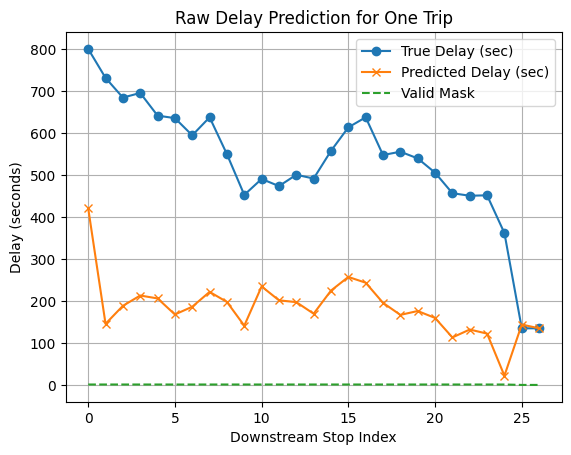

In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df_raw = pd.read_csv('Dataset-PT.csv', skiprows=1)

scaler_arrival = StandardScaler()
scaler_arrival.fit(df_raw[['arrival_delay']])  # now using truly unscaled data


i = 27  # sample index

# Inverse transform predictions and ground truth
true_raw = scaler_arrival.inverse_transform(y_test[i].reshape(-1, 1)).flatten()
pred_raw = scaler_arrival.inverse_transform(pred_linreg[i].reshape(-1, 1)).flatten()
mask = mask_test[i].astype(bool)

# Filter valid entries
true_valid = true_raw[mask]
pred_valid = pred_raw[mask]

# Compute metrics
rmse = np.sqrt(mean_squared_error(true_valid, pred_valid))
mae = mean_absolute_error(true_valid, pred_valid)
mape = np.mean(np.abs((true_valid - pred_valid) / np.maximum(np.abs(true_valid), 1e-5))) * 100
r2 = r2_score(true_valid, pred_valid)

# Print results
print("True Delay Vector (seconds):", true_raw)
print("Predicted Delay Vector (seconds):", pred_raw)
print("Valid Mask:", mask_test[i])
print(f"\n✅ RMSE: {rmse:.2f} seconds")
print(f"✅ MAE: {mae:.2f} seconds")
print(f"✅ MAPE: {mape:.2f}%")
print(f"✅ R² Score: {r2:.4f}")
# Plot
plt.plot(true_raw, label="True Delay (sec)", marker='o')
plt.plot(pred_raw, label="Predicted Delay (sec)", marker='x')
plt.plot(mask_test[i], label="Valid Mask", linestyle="--")
plt.title("Raw Delay Prediction for One Trip")
plt.xlabel("Downstream Stop Index")
plt.ylabel("Delay (seconds)")
plt.legend()
plt.grid(True)
plt.show()


In [31]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor

# --- Fit model ---
lgb = MultiOutputRegressor(LGBMRegressor(n_estimators=200, learning_rate=0.05))
lgb.fit(X_train, y_train)
pred_lgb = lgb.predict(X_test)

# --- Inverse transform using raw scaler ---
df_raw = pd.read_csv('Dataset-PT.csv', skiprows=1)
scaler_arrival = StandardScaler()
scaler_arrival.fit(df_raw[['arrival_delay']])
pred_lgb_inverse = scaler_arrival.inverse_transform(pred_lgb)
y_test_inverse = scaler_arrival.inverse_transform(y_test)

# --- Masked Metric Functions ---
def masked_mae(y_true, y_pred, mask):
    return [
        mean_absolute_error(y_true[mask[:, i] == 1, i], y_pred[mask[:, i] == 1, i])
        if mask[:, i].sum() > 0 else np.nan
        for i in range(y_true.shape[1])
    ]

def masked_rmse(y_true, y_pred, mask):
    return [
        np.sqrt(mean_squared_error(y_true[mask[:, i] == 1, i], y_pred[mask[:, i] == 1, i]))
        if mask[:, i].sum() > 0 else np.nan
        for i in range(y_true.shape[1])
    ]

def masked_r2(y_true, y_pred, mask):
    return [
        r2_score(y_true[mask[:, i] == 1, i], y_pred[mask[:, i] == 1, i])
        if mask[:, i].sum() > 0 else np.nan
        for i in range(y_true.shape[1])
    ]

def masked_mape(y_true, y_pred, mask):
    return [
        np.mean(np.abs((y_true[mask[:, i] == 1, i] - y_pred[mask[:, i] == 1, i]) /
                       np.maximum(np.abs(y_true[mask[:, i] == 1, i]), 1e-5))) * 100
        if mask[:, i].sum() > 0 else np.nan
        for i in range(y_true.shape[1])
    ]

# --- Compute metrics ---
mae_per_horizon = masked_mae(y_test_inverse, pred_lgb_inverse, mask_test)
rmse_per_horizon = masked_rmse(y_test_inverse, pred_lgb_inverse, mask_test)
r2_per_horizon = masked_r2(y_test_inverse, pred_lgb_inverse, mask_test)
mape_per_horizon = masked_mape(y_test_inverse, pred_lgb_inverse, mask_test)

# --- Combine and display as DataFrame ---
metrics_df = pd.DataFrame({
    'Horizon': range(1, len(r2_per_horizon) + 1),
    'MAE (sec)': mae_per_horizon,
    'RMSE (sec)': rmse_per_horizon,
    'R² Score': r2_per_horizon,
    'MAPE (%)': mape_per_horizon
})

print(metrics_df.head(27).to_string(index=False))



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8403
[LightGBM] [Info] Number of data points in the train set: 72696, number of used features: 55
[LightGBM] [Info] Start training from score -0.066009
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8403
[LightGBM] [Info] Number of data points in the train set: 72696, number of used features: 55
[LightGBM] [Info] Start training from score -0.017076
[LightGBM] [Warning] Found

In [32]:
print(mask_test[:, 26].sum())


0


True Delay Vector (seconds): [801.         732.         685.         696.         642.
 636.         595.         638.         550.         453.
 491.         474.         501.         492.         558.
 614.         638.         548.         556.         540.
 506.         457.         451.         452.         362.
 134.97223827 134.97223827]
Predicted Delay Vector (seconds): [810.69799949 746.90961322 769.65607018 774.18256778 713.29164357
 661.21950522 732.88762712 681.431397   709.67824769 604.49017478
 681.57725979 645.09930354 615.7534722  624.80070735 650.29901046
 740.24764416 710.84070179 612.21123301 584.84683427 496.47260669
 552.17918559 522.62426259 482.1887128  473.63103231 314.53770325
 135.08789277 134.97223827]
Valid Mask: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0]

✅ RMSE: 96.29 seconds
✅ MAE: 81.03 seconds
✅ MAPE: 15.24%
✅ R² Score: 0.1052


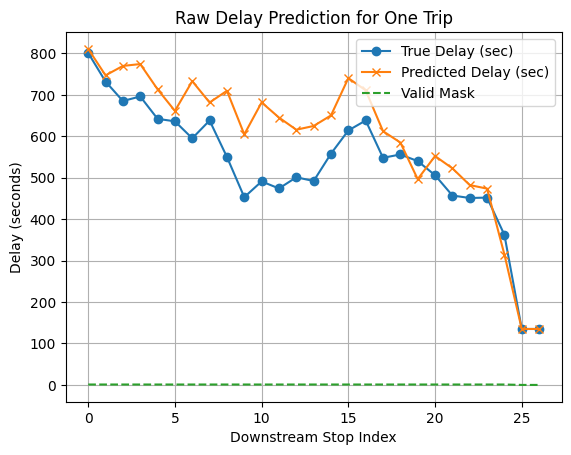

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df_raw = pd.read_csv('Dataset-PT.csv', skiprows=1)

scaler_arrival = StandardScaler()
scaler_arrival.fit(df_raw[['arrival_delay']])  # now using truly unscaled data


i = 27  # sample index

# Inverse transform predictions and ground truth
true_raw = scaler_arrival.inverse_transform(y_test[i].reshape(-1, 1)).flatten()
pred_raw = scaler_arrival.inverse_transform(pred_lgb[i].reshape(-1, 1)).flatten()
mask = mask_test[i].astype(bool)

# Filter valid entries
true_valid = true_raw[mask]
pred_valid = pred_raw[mask]

# Compute metrics
rmse = np.sqrt(mean_squared_error(true_valid, pred_valid))
mae = mean_absolute_error(true_valid, pred_valid)
mape = np.mean(np.abs((true_valid - pred_valid) / np.maximum(np.abs(true_valid), 1e-5))) * 100
r2 = r2_score(true_valid, pred_valid)

# Print results
print("True Delay Vector (seconds):", true_raw)
print("Predicted Delay Vector (seconds):", pred_raw)
print("Valid Mask:", mask_test[i])
print(f"\n✅ RMSE: {rmse:.2f} seconds")
print(f"✅ MAE: {mae:.2f} seconds")
print(f"✅ MAPE: {mape:.2f}%")
print(f"✅ R² Score: {r2:.4f}")
# Plot
plt.plot(true_raw, label="True Delay (sec)", marker='o')
plt.plot(pred_raw, label="Predicted Delay (sec)", marker='x')
plt.plot(mask_test[i], label="Valid Mask", linestyle="--")
plt.title("Raw Delay Prediction for One Trip")
plt.xlabel("Downstream Stop Index")
plt.ylabel("Delay (seconds)")
plt.legend()
plt.grid(True)
plt.show()


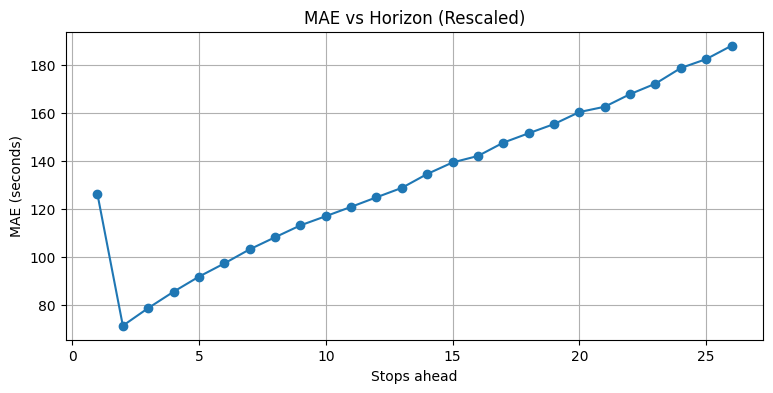

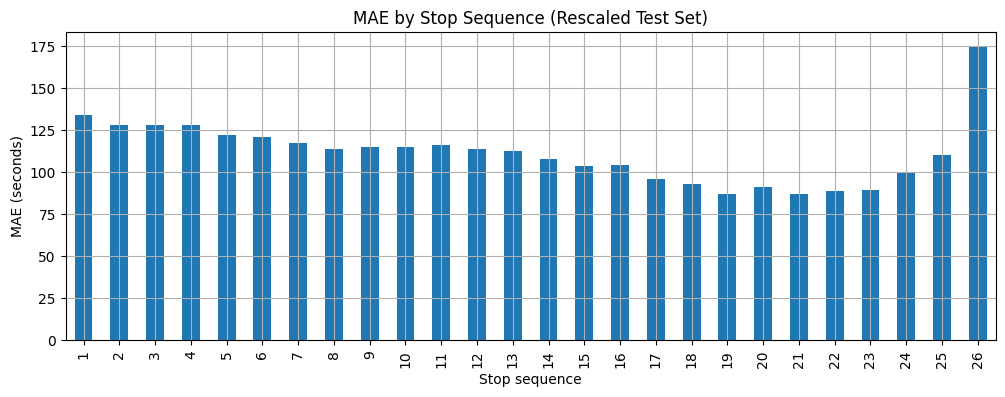

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Load raw data and fit scaler ---
df_raw = pd.read_csv('Dataset-PT.csv', skiprows=1)
scaler_arrival = StandardScaler()
scaler_arrival.fit(df_raw[['arrival_delay']])  # Fit on true unscaled data

# --- Inverse transform predictions and ground truth ---
def inverse_transform_per_column(scaler, data):
    return np.column_stack([
        scaler.inverse_transform(data[:, i].reshape(-1, 1)).flatten()
        for i in range(data.shape[1])
    ])

pred_inverse = inverse_transform_per_column(scaler_arrival, pred_lgb)
y_test_inverse = inverse_transform_per_column(scaler_arrival, y_test)

# --- Masked MAE function ---
def masked_mae(y_true, y_pred, mask):
    return [
        mean_absolute_error(y_true[mask[:, i] == 1, i], y_pred[mask[:, i] == 1, i])
        if mask[:, i].sum() > 0 else np.nan
        for i in range(y_true.shape[1])
    ]

# --- 1a: MAE vs Horizon (rescaled) ---
mae_horizons = masked_mae(y_test_inverse, pred_inverse, mask_test)
plt.figure(figsize=(9, 4))
plt.plot(range(1, len(mae_horizons) + 1), mae_horizons, marker='o')
plt.xlabel("Stops ahead")
plt.ylabel("MAE (seconds)")
plt.title("MAE vs Horizon (Rescaled)")
plt.grid(True)
plt.show()

# --- 1b: MAE by Stop Sequence (rescaled) ---
stop_seq_all = np.array([m[1] for m in meta])
stop_seq_test = stop_seq_all[test_idx]
unique_stops = np.unique(stop_seq_test)
mae_by_stop = []

for s in unique_stops:
    idx = (stop_seq_test == s)
    if idx.sum() == 0: continue
    y_s, p_s, m_s = y_test_inverse[idx], pred_inverse[idx], mask_test[idx]
    mae_s = masked_mae(y_s, p_s, m_s)
    mae_by_stop.append((s, np.nanmean(mae_s)))

mae_stop_df = pd.DataFrame(mae_by_stop, columns=["stop_seq", "mae"])
mae_stop_df.set_index("stop_seq", inplace=True)
mae_stop_df.plot(kind="bar", figsize=(12, 4), legend=False)
plt.xlabel("Stop sequence")
plt.ylabel("MAE (seconds)")
plt.title("MAE by Stop Sequence (Rescaled Test Set)")
plt.grid(True)
plt.show()






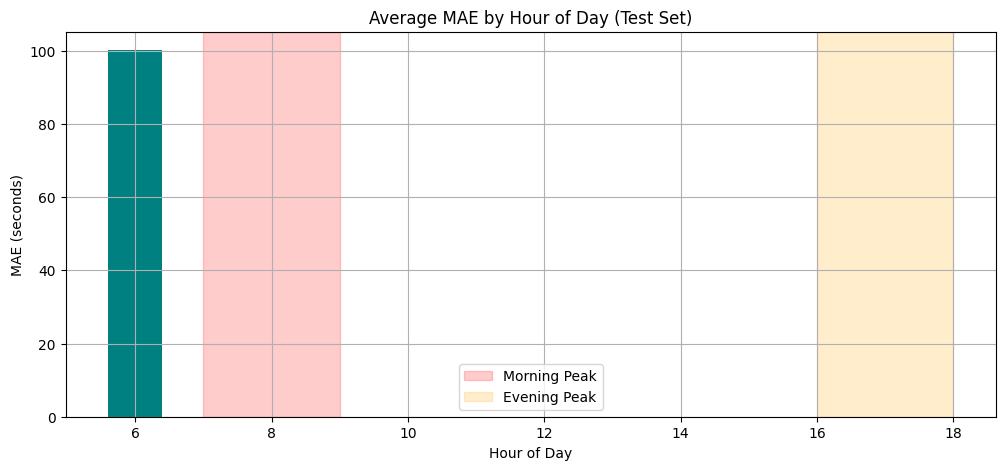

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/v


📊 Robustness Evaluation (MAE in seconds):
Clean Test MAE: 132.84
With Noise (10% Gaussian) MAE: 138.6
With Missing Features (20% zeroed) MAE: 149.78


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from copy import deepcopy

# --- Load raw data and fit scaler ---
df_raw = pd.read_csv('Dataset-PT.csv', skiprows=1)
scaler_arrival = StandardScaler()
scaler_arrival.fit(df_raw[['arrival_delay']])

# --- Inverse transform each column individually ---
def inverse_transform_per_column(scaler, data):
    return np.column_stack([
        scaler.inverse_transform(data[:, i].reshape(-1, 1)).flatten()
        for i in range(data.shape[1])
    ])

# --- Masked MAE ---
def masked_mae(y_true, y_pred, mask):
    return [
        mean_absolute_error(y_true[mask[:, i] == 1, i], y_pred[mask[:, i] == 1, i])
        if mask[:, i].sum() > 0 else np.nan
        for i in range(y_true.shape[1])
    ]

# --- Inverse transform predictions and ground truth ---
pred_inverse = inverse_transform_per_column(scaler_arrival, pred)
y_test_inverse = inverse_transform_per_column(scaler_arrival, y_test)

# ----------------- 1. Performance vs Time of Day -----------------
trip_first_time = df.groupby("trip_key")["actual_arrival_dt"].first().astype("datetime64[ns]")
sample_hours = np.array([trip_first_time[m[0]].hour for m in meta])
sample_hours_test = sample_hours[test_idx]

pred_mae, hour_bins = [], []
for h in range(6, 23):  # service hours 6am–10pm
    idx = (sample_hours_test == h)
    if idx.sum() == 0:
        continue
    y_h = y_test_inverse[idx]
    p_h = pred_inverse[idx]
    m_h = mask_test[idx]
    mae_h = masked_mae(y_h, p_h, m_h)
    pred_mae.append(np.nanmean(mae_h))
    hour_bins.append(h)

plt.figure(figsize=(12, 5))
plt.bar(hour_bins, pred_mae, color="teal")
plt.axvspan(7, 9, color="red", alpha=0.2, label="Morning Peak")
plt.axvspan(16, 18, color="orange", alpha=0.2, label="Evening Peak")
plt.title("Average MAE by Hour of Day (Test Set)")
plt.xlabel("Hour of Day")
plt.ylabel("MAE (seconds)")
plt.legend()
plt.grid(True)
plt.show()

# ----------------- 2. Robustness Checks -----------------
def robustness_check(model, X_test, y_test, mask_test, scenario="noise"):
    X_mod = deepcopy(X_test.values)

    if scenario == "noise":
        noise = np.random.normal(0, 0.1, size=X_mod.shape)  # 10% std noise
        X_mod += noise
    elif scenario == "missing":
        drop_rate = 0.2
        mask = np.random.rand(*X_mod.shape) < drop_rate
        X_mod[mask] = 0

    preds_scaled = model.predict(X_mod)
    preds_inverse = inverse_transform_per_column(scaler_arrival, preds_scaled)
    y_test_inverse = inverse_transform_per_column(scaler_arrival, y_test)

    mae_vals = masked_mae(y_test_inverse, preds_inverse, mask_test)
    return np.nanmean(mae_vals)

# --- Run robustness tests ---
mae_clean = np.nanmean(masked_mae(y_test_inverse, pred_inverse, mask_test))
mae_noise = robustness_check(lgb, X_test, y_test, mask_test, "noise")
mae_missing = robustness_check(lgb, X_test, y_test, mask_test, "missing")

print("\n📊 Robustness Evaluation (MAE in seconds):")
print("Clean Test MAE:", round(mae_clean, 2))
print("With Noise (10% Gaussian) MAE:", round(mae_noise, 2))
print("With Missing Features (20% zeroed) MAE:", round(mae_missing, 2))


In [37]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor

# --- Load raw data and fit scaler ---
df_raw = pd.read_csv('Dataset-PT.csv', skiprows=1)
scaler_arrival = StandardScaler()
scaler_arrival.fit(df_raw[['arrival_delay']])

# --- Inverse transform each column individually ---
def inverse_transform_per_column(scaler, data):
    return np.column_stack([
        scaler.inverse_transform(data[:, i].reshape(-1, 1)).flatten()
        for i in range(data.shape[1])
    ])

# --- Masked MAE ---
def masked_mae(y_true, y_pred, mask):
    return [
        mean_absolute_error(y_true[mask[:, i] == 1, i], y_pred[mask[:, i] == 1, i])
        if mask[:, i].sum() > 0 else np.nan
        for i in range(y_true.shape[1])
    ]

# --- Build sample → date mapping ---
trip_date_map = df.groupby("trip_key")["calendar_date"].first().to_dict()
sample_dates = np.array([trip_date_map[m[0]] for m in meta])
sample_dates = pd.to_datetime(sample_dates)

# --- Define month-level folds ---
months = pd.Series(sample_dates).dt.to_period("M").sort_values().unique().tolist()
if len(months) < 3:
    raise ValueError("Need at least 3 months for robust rolling evaluation.")

min_train_months = 2
fold_results = []

# --- Rolling origin evaluation ---
for i in range(min_train_months - 1, len(months) - 1):
    train_end = months[i]
    test_month = months[i + 1]

    train_idx = (pd.Series(sample_dates).dt.to_period("M") <= train_end).values
    test_idx  = (pd.Series(sample_dates).dt.to_period("M") == test_month).values
    if test_idx.sum() < 50:
        continue

    X_train_fold = X[train_idx]
    y_train_fold = Y[train_idx]
    mask_train_fold = MASK[train_idx]

    X_test_fold = X[test_idx]
    y_test_fold = Y[test_idx]
    mask_test_fold = MASK[test_idx]

    # --- Train model on fold ---
    model = MultiOutputRegressor(LGBMRegressor(
        n_estimators=200,
        learning_rate=0.05,
        num_leaves=64,
        random_state=42,
        n_jobs=-1
    ))
    model.fit(X_train_fold.values, y_train_fold)

    # --- Predict and inverse transform ---
    y_pred_fold_scaled = model.predict(X_test_fold.values)
    y_pred_fold = inverse_transform_per_column(scaler_arrival, y_pred_fold_scaled)
    y_test_fold = inverse_transform_per_column(scaler_arrival, y_test_fold)

    # --- Evaluate MAE per horizon ---
    mae_h = masked_mae(y_test_fold, y_pred_fold, mask_test_fold)
    fold_results.append({
        "train_end": str(train_end),
        "test_month": str(test_month),
        "mae_horizon": mae_h,
        "n_test": int(test_idx.sum())
    })
    print(f"Fold train_end={train_end} test={test_month} n_test={test_idx.sum()} overall_mae={np.nanmean(mae_h):.2f} sec")

# --- Aggregate results across folds ---
mae_matrix = np.array([fr["mae_horizon"] for fr in fold_results])
horizon_mean = np.nanmean(mae_matrix, axis=0)
horizon_std  = np.nanstd(mae_matrix, axis=0)

# --- Print summary for first 10 horizons ---
print("\n📊 Rolling Origin MAE Summary (seconds):")
for h in range(10):
    print(f"Horizon {h+1}: MAE = {horizon_mean[h]:.2f} ± {horizon_std[h]:.2f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8019
[LightGBM] [Info] Number of data points in the train set: 33306, number of used features: 55
[LightGBM] [Info] Start training from score -0.118662
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.140841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8019
[LightGBM] [Info] Number of data points in the train set: 33306, number of used features: 55
[LightGBM] [Info] Start training from score -0.035467
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/v

Fold train_end=2022-02 test=2022-03 n_test=20722 overall_mae=94.52 sec
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8294
[LightGBM] [Info] Number of data points in the train set: 54028, number of used features: 55
[LightGBM] [Info] Start training from score -0.105144
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8294
[LightGBM] [Info] Number of data points in the train set: 54028, number of used features: 55
[LightGBM] [Info] Start training from score -0.024168
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013006 seconds.
You can set

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/v

Fold train_end=2022-03 test=2022-04 n_test=18668 overall_mae=96.13 sec
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8403
[LightGBM] [Info] Number of data points in the train set: 72696, number of used features: 55
[LightGBM] [Info] Start training from score -0.066009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8403
[LightGBM] [Info] Number of data points in the train set: 72696, number of used features: 55
[LightGBM] [Info] Start training from score -0.017076
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016653 seconds.
You can set

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/v

Fold train_end=2022-04 test=2022-05 n_test=18538 overall_mae=101.27 sec
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8490
[LightGBM] [Info] Number of data points in the train set: 91234, number of used features: 55
[LightGBM] [Info] Start training from score -0.073051
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8490
[LightGBM] [Info] Number of data points in the train set: 91234, number of used features: 55
[LightGBM] [Info] Start training from score -0.012076
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020810 seconds.
You can se

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/v

Fold train_end=2022-05 test=2022-06 n_test=15704 overall_mae=130.98 sec

📊 Rolling Origin MAE Summary (seconds):
Horizon 1: MAE = 112.52 ± 8.75
Horizon 2: MAE = 46.84 ± 12.74
Horizon 3: MAE = 54.65 ± 12.80
Horizon 4: MAE = 60.50 ± 13.43
Horizon 5: MAE = 66.23 ± 13.68
Horizon 6: MAE = 71.40 ± 13.52
Horizon 7: MAE = 77.34 ± 14.00
Horizon 8: MAE = 82.16 ± 13.67
Horizon 9: MAE = 87.24 ± 13.77
Horizon 10: MAE = 91.86 ± 13.58


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/tmp/ipython-input-542509810.py:86: RuntimeWarning: Mean of empty slice
  horizon_mean = np.nanmean(mae_matrix, axis=0)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [38]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor

# --- Load raw data and fit scaler ---
df_raw = pd.read_csv('Dataset-PT.csv', skiprows=1)
scaler_arrival = StandardScaler()
scaler_arrival.fit(df_raw[['arrival_delay']])

# --- Inverse transform each column individually ---
def inverse_transform_per_column(scaler, data):
    return np.column_stack([
        scaler.inverse_transform(data[:, i].reshape(-1, 1)).flatten()
        for i in range(data.shape[1])
    ])

# --- Masked MAE function ---
def masked_mae(y_true, y_pred, mask):
    return [
        mean_absolute_error(y_true[mask[:, i] == 1, i], y_pred[mask[:, i] == 1, i])
        if mask[:, i].sum() > 0 else np.nan
        for i in range(y_true.shape[1])
    ]

# --- Aggregate MAE across horizons ---
def aggregate_masked(mae_list):
    valid_mae = [m for m in mae_list if not np.isnan(m)]
    return np.mean(valid_mae)

# --- Simulate noise and evaluate impact ---
def simulate_noise(feature_name, sigmas=[0.1, 0.5, 1.0, 2.0]):
    X_test_arr = X_test.copy().astype(float)
    std = X_test_arr[feature_name].std()
    results = {}

    for s in sigmas:
        X_mod = X_test_arr.copy()
        noise = np.random.RandomState(0).normal(0, s * std, size=len(X_mod))
        X_mod[feature_name] += noise

        # Predict with noisy input
        pred_mod_scaled = lgb.predict(X_mod.values)

        # Inverse transform predictions and ground truth
        pred_mod_inverse = inverse_transform_per_column(scaler_arrival, pred_mod_scaled)
        y_test_inverse = inverse_transform_per_column(scaler_arrival, y_test)

        # Compute masked MAE in seconds
        mae = aggregate_masked(masked_mae(y_test_inverse, pred_mod_inverse, mask_test))
        results[s] = mae
        print(f"Noise {s} sigma → MAE: {mae:.2f} sec")

    return results

# --- Run simulation on upstream_stop_delay ---
if "upstream_stop_delay" in X_test.columns:
    simulate_noise("upstream_stop_delay", sigmas=[0.1, 0.5, 1.0, 2.0])


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/v

Noise 0.1 sigma → MAE: 134.80 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/v

Noise 0.5 sigma → MAE: 164.07 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/v

Noise 1.0 sigma → MAE: 200.68 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/v

Noise 2.0 sigma → MAE: 246.07 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [39]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import models, layers, callbacks

# --- Load raw data and fit scaler ---
df_raw = pd.read_csv('Dataset-PT.csv', skiprows=1)
scaler_arrival = StandardScaler()
scaler_arrival.fit(df_raw[['arrival_delay']])

# --- Build sequence data ---
def build_seq_data(X_df, Y_arr, mask_arr, max_len=27):
    Xarr = X_df.values.astype(np.float32)
    n, f = Xarr.shape
    Xseq = np.repeat(Xarr[:, None, :], max_len, axis=1)  # [n, max_len, f]
    Yseq = Y_arr[:, :max_len].reshape(n, max_len, 1)
    return Xseq, Yseq, mask_arr[:, :max_len]

Xtr_s, ytr_s, mtr_s = build_seq_data(X_train, y_train, mask_train)
Xv_s,  yv_s,  mv_s  = build_seq_data(X_val,   y_val,   mask_val)
Xte_s, yte_s, mte_s = build_seq_data(X_test,  y_test,  mask_test)

# --- Define LSTM Seq2Seq model ---
model = models.Sequential([
    layers.Masking(mask_value=0., input_shape=(Xtr_s.shape[1], Xtr_s.shape[2])),
    layers.LSTM(128, return_sequences=True),
    layers.TimeDistributed(layers.Dense(1))
])
model.compile(optimizer="adam", loss="mae")

# --- Train model ---
model.fit(
    Xtr_s, ytr_s,
    validation_data=(Xv_s, yv_s),
    epochs=30,
    batch_size=64,
    callbacks=[callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

# --- Predict and reshape ---
pred_seq = model.predict(Xte_s).reshape(Xte_s.shape[0], Xte_s.shape[1])

# --- Inverse transform each column individually ---
def inverse_transform_per_column(scaler, data):
    return np.column_stack([
        scaler.inverse_transform(data[:, i].reshape(-1, 1)).flatten()
        for i in range(data.shape[1])
    ])

# Apply inverse transform
pred_seq_inverse = inverse_transform_per_column(scaler_arrival, pred_seq)
y_test_inverse = inverse_transform_per_column(scaler_arrival, y_test)

# --- Masked metric functions ---
def masked_mae(y_true, y_pred, mask):
    return [
        mean_absolute_error(y_true[mask[:, i] == 1, i], y_pred[mask[:, i] == 1, i])
        if mask[:, i].sum() > 0 else np.nan
        for i in range(y_true.shape[1])
    ]

def masked_rmse(y_true, y_pred, mask):
    return [
        np.sqrt(mean_squared_error(y_true[mask[:, i] == 1, i], y_pred[mask[:, i] == 1, i]))
        if mask[:, i].sum() > 0 else np.nan
        for i in range(y_true.shape[1])
    ]

def masked_r2(y_true, y_pred, mask):
    return [
        r2_score(y_true[mask[:, i] == 1, i], y_pred[mask[:, i] == 1, i])
        if mask[:, i].sum() > 0 else np.nan
        for i in range(y_true.shape[1])
    ]

def masked_mape(y_true, y_pred, mask):
    return [
        np.mean(np.abs((y_true[mask[:, i] == 1, i] - y_pred[mask[:, i] == 1, i]) /
                       np.maximum(np.abs(y_true[mask[:, i] == 1, i]), 1e-5))) * 100
        if mask[:, i].sum() > 0 else np.nan
        for i in range(y_true.shape[1])
    ]

# --- Compute metrics ---
mae_lstm = masked_mae(y_test_inverse, pred_seq_inverse, mask_test)
rmse_lstm = masked_rmse(y_test_inverse, pred_seq_inverse, mask_test)
r2_lstm = masked_r2(y_test_inverse, pred_seq_inverse, mask_test)
mape_lstm = masked_mape(y_test_inverse, pred_seq_inverse, mask_test)

# --- Combine into DataFrame ---
metrics_df = pd.DataFrame({
    "Horizon": range(1, len(mae_lstm) + 1),
    "MAE (sec)": mae_lstm,
    "RMSE (sec)": rmse_lstm,
    "R² Score": r2_lstm,
    "MAPE (%)": mape_lstm
})

# --- Display results ---
print(metrics_df.head(27).to_string(index=False))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 75s 62ms/step - loss: 0.0889 - val_loss: 0.0769
Epoch 2/30
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 73s 64ms/step - loss: 0.0709 - val_loss: 0.0708
Epoch 3/30
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 73s 64ms/step - loss: 0.0647 - val_loss: 0.0745
Epoch 4/30
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 71s 62ms/step - loss: 0.0598 - val_loss: 0.0601
Epoch 5/30
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 71s 63ms/step - loss: 0.0542 - val_loss: 0.0587
Epoch 6/30
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 71s 62ms/step - loss: 0.0501 - val_loss: 0.0534
Epoch 7/30
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 71s 63ms/step - loss: 0.0481 - val_loss: 0.0530
Epoch 8/30
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 70s 62ms/step - loss: 0.0476 - val_loss: 0.0539
Epoch 9/30
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 70s 62ms/step - loss: 0.0466 - val_loss: 0.0513
Epoch 10/30
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 71s 63ms/step - loss: 0.0450 - val_loss: 0.0507
Epoch 11/30
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 82s 63ms/step - loss: 0.0442 - val_loss: 0.0501
Epoch 12

True Delay Vector (seconds): [801.         732.         685.         696.         642.
 636.         595.         638.         550.         453.
 491.         474.         501.         492.         558.
 614.         638.         548.         556.         540.
 506.         457.         451.         452.         362.
 134.97223827 134.97223827]
Predicted Delay Vector (seconds): [566.47784 725.3239  713.5463  695.73175 686.9676  690.07776 701.5858
 717.0494  735.0088  752.0418  766.37463 778.8437  791.6282  804.13934
 810.71594 808.6826  800.90265 790.2933  777.8928  761.8205  742.67505
 721.8936  701.83185 681.31525 655.1102  604.85315 488.22516]
Valid Mask: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0]

✅ RMSE: 215.94 seconds
✅ MAE: 191.71 seconds
✅ MAPE: 37.66%
✅ R² Score: -3.5000


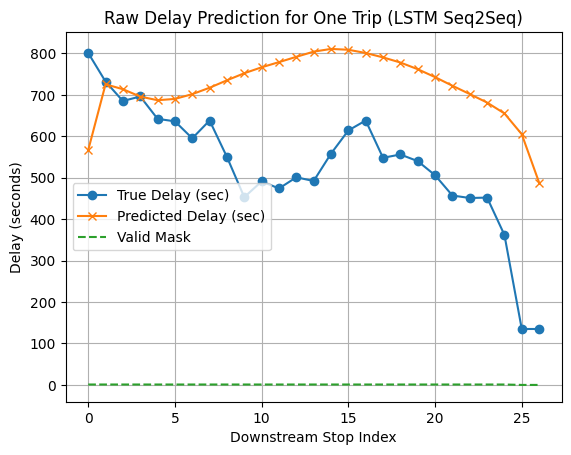

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Load original, unscaled data ---
df_raw = pd.read_csv('Dataset-PT.csv', skiprows=1)

# --- Fit scaler on raw arrival_delay values ---
scaler_arrival = StandardScaler()
scaler_arrival.fit(df_raw[['arrival_delay']])

# --- Select sample index ---
i = 27  # Change this to evaluate a different trip

# --- Inverse transform predictions and ground truth ---
true_raw = scaler_arrival.inverse_transform(y_test[i].reshape(-1, 1)).flatten()
pred_raw = scaler_arrival.inverse_transform(pred_seq[i].reshape(-1, 1)).flatten()
mask = mask_test[i].astype(bool)

# --- Filter valid entries ---
true_valid = true_raw[mask]
pred_valid = pred_raw[mask]

# --- Compute metrics ---
rmse = np.sqrt(mean_squared_error(true_valid, pred_valid))
mae = mean_absolute_error(true_valid, pred_valid)
mape = np.mean(np.abs((true_valid - pred_valid) / np.maximum(np.abs(true_valid), 1e-5))) * 100
r2 = r2_score(true_valid, pred_valid)

# --- Print results ---
print("True Delay Vector (seconds):", true_raw)
print("Predicted Delay Vector (seconds):", pred_raw)
print("Valid Mask:", mask_test[i])
print(f"\n✅ RMSE: {rmse:.2f} seconds")
print(f"✅ MAE: {mae:.2f} seconds")
print(f"✅ MAPE: {mape:.2f}%")
print(f"✅ R² Score: {r2:.4f}")

# --- Plot results ---
plt.plot(true_raw, label="True Delay (sec)", marker='o')
plt.plot(pred_raw, label="Predicted Delay (sec)", marker='x')
plt.plot(mask_test[i], label="Valid Mask", linestyle="--")
plt.title("Raw Delay Prediction for One Trip (LSTM Seq2Seq)")
plt.xlabel("Downstream Stop Index")
plt.ylabel("Delay (seconds)")
plt.legend()
plt.grid(True)
plt.show()
